In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False

import openpyxl

In [2]:
Para_Ecker2015=pb.ParameterValues(chemistry=pb.parameter_sets.Ecker2015)
Para_Chen2020_coupled=pb.ParameterValues(chemistry=pb.parameter_sets.Chen2020_coupled)

In [3]:
Model_0  = pb.lithium_ion.DFN()
ChemistryChen=pb.parameter_sets.Chen2020   # Ren2018  Chen2020_plating
param=pb.ParameterValues(chemistry=ChemistryChen);

R   = param.evaluate(Model_0.param.R)

In [4]:
print(R)

8.314462618


In [20]:
# Check exchange current density 
def graphite_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, T):
    m_ref = 1e-5  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 35000
    arrhenius =np.exp(E_r / R* (1 / 298.15 - 1 / T))
    c_n_max = 33133
    return ( m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_n_max - c_s_surf) ** 0.5 ).value
def graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 12.4  # (A/m2) replaced with value from Schmalstieg et al. (2018), from 2.668 
    alpha = 0.792
    E_r = 4e4
    arrhenius = np.exp(E_r / R * (1 / 298.15 - 1 / T))

    c_n_max = 29583
    c_e_ref = 1000
    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_n_max) ** alpha
        * (1 - c_s_surf / c_n_max) ** (1 - alpha))
def nmc_LGM50_electrolyte_exchange_current_density_Chen2020(c_e, c_s_surf, T):
    m_ref = 3.42e-6  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 17800
    arrhenius =np.exp(E_r / R* (1 / 298.15 - 1 / T))
    c_p_max = 63104
    return ( m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_p_max - c_s_surf) ** 0.5  ).value

def nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust(c_e, c_s_surf, T):
    i_ref = 5.028  # (A/m2)
    alpha = 0.43
    E_r = 2.401e4
    arrhenius = np.exp(E_r / R * (1 / 298.15 - 1 / T))
    c_p_max = 51765
    c_e_ref = 1000
    return (
        i_ref
        * arrhenius
        * (c_e / c_e_ref) ** (1 - alpha)
        * (c_s_surf / c_p_max) ** alpha
        * (1 - c_s_surf / c_p_max) ** (1 - alpha))

def graphite_electrolyte_exchange_current_density_Ecker2015(c_e, c_s_surf, T,Para):
    k_ref = 1.995 * 1e-10
    m_ref = constants.F * k_ref  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 53400
    arrhenius =np.exp(-E_r / (R* T)) *np.exp(E_r / (R* 296.15))
    c_n_max = Para["Maximum concentration in negative electrode [mol.m-3]"]
    return (m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_n_max - c_s_surf) ** 0.5).value

def nco_electrolyte_exchange_current_density_Ecker2015(c_e, c_s_surf, T,Para):
    k_ref = 5.196e-11
    m_ref = constants.F * k_ref  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 4.36e4
    arrhenius =np.exp(-E_r / (R* T)) *np.exp(E_r / (R* 296.15))
    c_p_max = Para["Maximum concentration in positive electrode [mol.m-3]"]
    return (  m_ref * arrhenius * c_e ** 0.5 * c_s_surf ** 0.5 * (c_p_max - c_s_surf) ** 0.5).value

c_e = np.arange(700,1300.0,10.0); Temp_i = 273.15+45 ; NegSOC = np.arange(0.03,0.95,0.01); PosSOC = np.arange(0.3,0.95,0.01);
i0_neg_Chen =[]; i0_pos_Chen = []; i0_neg_ORegan =[]; i0_pos_ORegan = [];i0_neg_Ecker =[]; i0_pos_Ecker = [];
for NegSOC_i in NegSOC:
    i0_neg_Chen.append  (   graphite_LGM50_electrolyte_exchange_current_density_Chen2020  (
        1000, NegSOC_i*33133, Temp_i  ) ) 
    i0_neg_ORegan.append   (   graphite_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust         (
        1000, NegSOC_i*29583, Temp_i ) ) 
    i0_neg_Ecker.append (   graphite_electrolyte_exchange_current_density_Ecker2015       (
        1000, NegSOC_i*Para_Ecker2015["Maximum concentration in negative electrode [mol.m-3]"], Temp_i, Para_Ecker2015  ) )

for PosSOC_i in PosSOC:
    i0_pos_Chen.append  (   nmc_LGM50_electrolyte_exchange_current_density_Chen2020       (
        1000, PosSOC_i*63104, Temp_i  ) )
    i0_pos_ORegan.append   (   nmc_LGM50_electrolyte_exchange_current_density_ORegan2021_adjust              (
        1000, PosSOC_i*51765, Temp_i  ) )
    i0_pos_Ecker.append (   nco_electrolyte_exchange_current_density_Ecker2015            (
        1000, PosSOC_i*Para_Ecker2015["Maximum concentration in positive electrode [mol.m-3]"], Temp_i, Para_Ecker2015  ) )



In [41]:
print(R)

8.314462618


In [6]:
# Compare diffusivity of electrode:
NegSOC = np.arange(0.03,0.95,0.01); PosSOC = np.arange(0.03,0.95,0.01);

def graphite_LGM50_diffusivity_Chen2020(sto, T):
    D_ref = 3.3e-14
    E_D_s = 30000  # assumed
    arrhenius =np.exp(E_D_s / R* (1 / 298.15 - 1 / T))
    return D_ref * arrhenius
def graphite_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a0 = 11.17
    a1 = -1.553
    a2 = -6.136
    a3 = -9.725
    a4 = 1.85
    b1 = 0.2031
    b2 = 0.5375
    b3 = 0.9144
    b4 = 0.5953
    c0 = -15.11
    c1 = 0.0006091
    c2 = 0.06438
    c3 = 0.0578
    c4 = 0.001356
    d = 2092

    D_ref = (
        10
        ** (
            a0 * sto
            + c0
            + a1 *np.exp(-((sto - b1) ** 2) / c1)
            + a2 *np.exp(-((sto - b2) ** 2) / c2)
            + a3 *np.exp(-((sto - b3) ** 2) / c3)
            + a4 *np.exp(-((sto - b4) ** 2) / c4)
        )
        * 20  # correcting factor (see O'Regan et al 2021) mark: Ruihe change from 3.0321 
    )

    E_D_s = d * R
    arrhenius =np.exp(E_D_s / R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

def nmc_LGM50_diffusivity_Chen2020(sto, T):
    D_ref = 4e-15
    E_D_s = 25000  # Used value from Cabanero et al. (2018) for NCA
    arrhenius =np.exp(E_D_s / R* (1 / 298.15 - 1 / T))
    return D_ref * arrhenius

def nmc_LGM50_diffusivity_ORegan2021_adjust(sto, T):
    a1 = -0.9231
    a2 = -0.4066
    a3 = -0.993
    b1 = 0.3216
    b2 = 0.4532
    b3 = 0.8098
    c0 = -13.96
    c1 = 0.002534
    c2 = 0.003926
    c3 = 0.09924
    d = 1449

    D_ref = (
        10
        ** (
            c0
            + a1 *np.exp(-((sto - b1) ** 2) / c1)
            + a2 *np.exp(-((sto - b2) ** 2) / c2)
            + a3 *np.exp(-((sto - b3) ** 2) / c3)
        )
        * 10  # correcting factor (see O'Regan et al 2021), mark Ruihe change from 2.7 to 10
    )

    E_D_s = d * R
    arrhenius =np.exp(E_D_s / R* (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

Diff_neg_Chen =[]; Diff_pos_Chen = []; Diff_neg_ORegan =[]; Diff_pos_ORegan = [];Diff_neg_Ecker =[]; Diff_pos_Ecker = [];
for NegSOC_i in NegSOC:
    Diff_neg_Chen.append  (   graphite_LGM50_diffusivity_Chen2020  (
        NegSOC_i*33133, 298.15  ) ) 
    Diff_neg_ORegan.append   (   graphite_LGM50_diffusivity_ORegan2021_adjust         (
        NegSOC_i*29583, 298.15  ) ) 

for PosSOC_i in PosSOC:
    Diff_pos_Chen.append  (   nmc_LGM50_diffusivity_Chen2020       (
        PosSOC_i*63104, 298.15  ) )
    Diff_pos_ORegan.append   (   nmc_LGM50_diffusivity_ORegan2021_adjust              (
        PosSOC_i*51765, 298.15  ) )


C:\Users\rl1120\AppData\Local\Temp\ipykernel_720\3562702845.py:27: RuntimeWarning: overflow encountered in double_scalars
  10


str = 'Chen2020_coupled';
ChemistryChen=pb.parameter_sets.+str

Text(0.5, 1.0, 'Positive electrode')

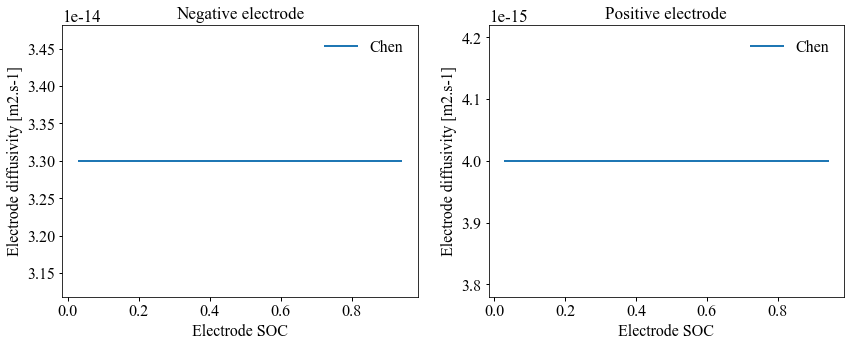

In [7]:
fs = 16;  lw = 2;
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].plot(NegSOC, Diff_neg_Chen, lw=2, label='Chen') 
#axs[0].plot(NegSOC, Diff_neg_ORegan, lw=2, label='ORegan') 

axs[0].set_xlabel("Electrode SOC", fontdict={'family':'Times New Roman','size':fs})
axs[0].set_ylabel("Electrode diffusivity [m2.s-1]", fontdict={'family':'Times New Roman','size':fs})
labels = axs[0].get_xticklabels() + axs[0].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[0].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[0].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[0].set_title("Negative electrode",   fontdict={'family':'Times New Roman','size':fs+1})

axs[1].plot(PosSOC, Diff_pos_Chen, lw=2, label='Chen') 
#axs[1].plot(PosSOC, Diff_pos_ORegan, lw=2, label='ORegan') 
axs[1].set_xlabel("Electrode SOC", fontdict={'family':'Times New Roman','size':fs})
axs[1].set_ylabel("Electrode diffusivity [m2.s-1]", fontdict={'family':'Times New Roman','size':fs})
labels = axs[1].get_xticklabels() + axs[1].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[1].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[1].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[1].set_title("Positive electrode",   fontdict={'family':'Times New Roman','size':fs+1})

In [22]:
# Define electrolyte diffusivity and conductivity
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_conductivity_Valoen2005(c_e, T):   # valid concentration: 0~4000 mol/m3
    sigma_e = 0.1 * (-10.5 + 0.668*(1e-3*c_e) + 0.494*(1e-6*c_e**2) + 0.074*T - 0.0178*(1e-3*c_e)*T - 8.86e-4*(1e-6*c_e**2)*T - 6.96e-5*T**2 + 2.8E-5*(1E-3*c_e)*T**2 ) **2 * (1e-3*c_e)
    return sigma_e
def electrolyte_diffusivity_Valoen2005(c_e, T):
    D_c_e = 1e-4 * 10**(-4.43 - 54/(T - 229 - 0.005*c_e) - 2.2e-4 * c_e   )
    return D_c_e

def electrolyte_conductivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # Add temperature dependence
    E_k_e = 1.71e4
    C = 296 *np.exp(E_k_e / (R* 296))
    sigma_e = C * sigma_e_296 *np.exp(-E_k_e / (R* T)) / T
    return sigma_e.value
def electrolyte_diffusivity_Ecker2015(c_e, T):
    # mol/m^3 to mol/l
    cm = 1e-3 * c_e
    # value at T = 296K
    sigma_e_296 = 0.2667 * cm ** 3 - 1.2983 * cm ** 2 + 1.7919 * cm + 0.1726
    # add temperature dependence
    E_k_e = 1.71e4
    C = 296 *np.exp(E_k_e / (R* 296))
    sigma_e = C * sigma_e_296 *np.exp(-E_k_e / (R* T)) / T
    D_c_e = (constants.k_b / (constants.F * constants.q_e)) * sigma_e * T / c_e
    return D_c_e.value

def electrolyte_conductivity_Ding2001(c_e, c_EC,  T):
    # c_e is lithium ion concentration in electrolyte in mol/m3, need to change to mol/kg
    # also be careful that T here is deg, while others are K
    rho_electrolyte = 1300 # in kg/m3
    c_e_kg = c_e / rho_electrolyte     # in mol/kg 
    M_LiPF6 = 151.905/1000  # kg/mol
    M_EC = 88.062/1000  # kg/mol
    M_EMC = 104.104/1000 # kg/mol
    x_EC = 1 / (1+ ( rho_electrolyte - c_e*M_LiPF6 - c_EC*M_EC  )/M_EMC/c_EC   )
    kai = -3.37115 + 12.5608*c_e_kg - 7.89593*c_e_kg**2 + 3.51922*c_e_kg**3-1.15471*c_e_kg**4 +18.1863*x_EC - 6.22756*c_e_kg*x_EC - 13.6916*c_e_kg**2*x_EC +8.43904*c_e_kg**3*x_EC - 7.83732*x_EC**2 + 19.607*c_e_kg*x_EC**2  - 18.4529*c_e_kg**2*x_EC**2 -30.6369*x_EC**3 + 29.2*c_e_kg*x_EC**3 - 0.0429918*T + 0.180877*c_e_kg*T -0.0836202*c_e_kg**2*T + 0.0230098*c_e_kg**3*T + 0.195946*T*x_EC +0.0676686*c_e_kg*x_EC*T - 0.14134*c_e_kg**2*x_EC*T + 0.147429*x_EC**2*T  +0.173059*c_e_kg*x_EC**2*T - 0.51634*x_EC**3*T - 0.000223097*T**2 +0.000111233*c_e_kg*T**2 + 0.0000495286*c_e_kg**2*T**2  +0.000952777*x_EC*T**2 + 0.00117334 *c_e_kg*x_EC*T**2-0.000619157*x_EC**2*T**2 - 3.46897E-7*T**3 - 2.75041E-6*c_e_kg*T**3 -5.57653E-6*x_EC*T**3 
    return kai 

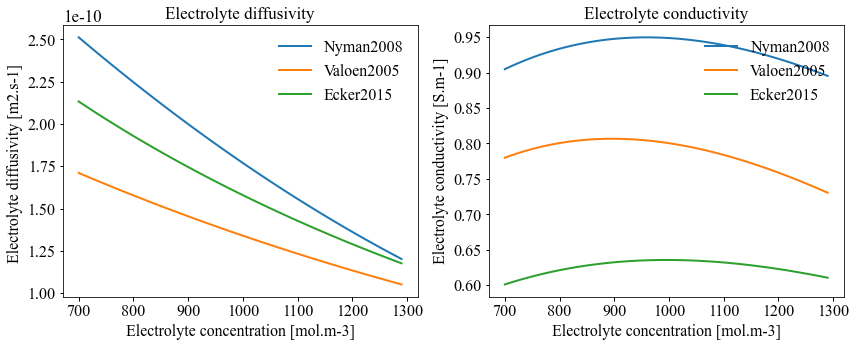

In [25]:
ce = np.arange(700,1300.0,10.0); T = np.full(ce.shape,298.15) ; c_EC = np.full(ce.shape,4540.0)  # standard T is 273.15; 25=298.15;     paper is 0.4 to 3.4 M experimentally; and 10 to 4000 curve fit
# ce = 1200.3; T = 298.15; # T = np.full(ce.shape,298.15) 
# T = np.full(np.size(ce),298.15) 
Temp_i = 273.15+5 ;
sigma_e_Nyman2008 =[]; D_c_e_Nyman2008 = []; sigma_e_Valoen2005 =[]; D_c_e_Valoen2005 = []; sigma_e_Ecker2015 =[]; D_c_e_Ecker2015 = []; 
sigma_e_Ding2001 =[]; 
# sigma_e = np.full(ce.shape,0.0); D_c_e  = np.full(ce.shape,0.0);  #  
for ce_i in ce:
    # print(type(i))
    # print(ce[i])       
    # print(type(electrolyte_conductivity_Valoen2005(ce[i], T[i])))
    # print(dir(electrolyte_conductivity_Valoen2005(ce[i], T[i])))
    # print(electrolyte_conductivity_Valoen2005(ce[i], T[i]).data)
    # print(sigma_e[i])      
    sigma_e_Nyman2008.append(   electrolyte_conductivity_Nyman2008(ce_i, Temp_i)  ) 
    D_c_e_Nyman2008.append  (   electrolyte_diffusivity_Nyman2008 (ce_i, Temp_i)    )
    sigma_e_Valoen2005.append(   electrolyte_conductivity_Valoen2005(ce_i, Temp_i)  ) 
    D_c_e_Valoen2005.append  (   electrolyte_diffusivity_Valoen2005 (ce_i, Temp_i)    )
    sigma_e_Ecker2015.append(   electrolyte_conductivity_Ecker2015(ce_i, Temp_i)  ) 
    D_c_e_Ecker2015.append  (   electrolyte_diffusivity_Ecker2015(ce_i, Temp_i)    )
    sigma_e_Ding2001.append(   electrolyte_conductivity_Ding2001(ce_i,4340, Temp_i)  ) 


fs = 16;  lw = 2;
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].plot(list(ce), D_c_e_Nyman2008, lw=2, label='Nyman2008') 
axs[0].plot(list(ce), D_c_e_Valoen2005, lw=2, label='Valoen2005') 
axs[0].plot(list(ce), D_c_e_Ecker2015 , lw=2, label='Ecker2015') 
axs[0].set_xlabel("Electrolyte concentration [mol.m-3]", fontdict={'family':'Times New Roman','size':fs})
axs[0].set_ylabel("Electrolyte diffusivity [m2.s-1] ", fontdict={'family':'Times New Roman','size':fs})
labels = axs[0].get_xticklabels() + axs[0].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[0].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[0].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[0].set_title("Electrolyte diffusivity",   fontdict={'family':'Times New Roman','size':fs+1})

axs[1].plot(list(ce), sigma_e_Nyman2008, lw=2, label='Nyman2008') 
axs[1].plot(list(ce), sigma_e_Valoen2005, lw=2, label='Valoen2005') 
axs[1].plot(list(ce), sigma_e_Ecker2015 , lw=2, label='Ecker2015')  
# axs[1].plot(list(ce), sigma_e_Ding2001 , lw=2, label='Ding2001')
axs[1].set_xlabel("Electrolyte concentration [mol.m-3]", fontdict={'family':'Times New Roman','size':fs})
axs[1].set_ylabel("Electrolyte conductivity [S.m-1]", fontdict={'family':'Times New Roman','size':fs})
labels = axs[1].get_xticklabels() + axs[1].get_yticklabels(); [label.set_fontname('Times New Roman') for label in labels]
axs[1].tick_params(labelcolor='k', labelsize=fs, width=1) ; del labels;
axs[1].legend(prop={'family':'Times New Roman','size':fs},loc='best',frameon=False)
axs[1].set_title("Electrolyte conductivity",   fontdict={'family':'Times New Roman','size':fs+1})

BasicPath = 'D:/OneDrive - Imperial College London/PhD Study/Imperial Study/Model/Pybamm Learning/SimDataSave/SolConsumed/' ;
SpeciPath = 'InputData/'     #  Name the main purpose of this run here
WholePath = BasicPath + SpeciPath

#plt.savefig(WholePath+"Compare Electrolyte conductivity and diffusivity.png", dpi=600)
#plt.savefig(WholePath+"Compare Electrolyte conductivity and diffusivity.svg")